In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_svmlight_file

from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance

import lightgbm as lgb

In [248]:
data = pd.read_csv("dataset/training.csv", sep=",")
data = data.drop(data.columns[[6,7,8,10]], axis=1)
data = data.dropna()

# Sainty Check
print(data.shape)
data.head()
data.describe()

(793, 8)


,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,USG,perf_class
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,3.614124,3.517024,4.804540,4.089533,8.339849,3.453972,1.022636,0.757881
std,0.865968,1.161254,1.014232,0.537300,0.909171,1.174524,0.029400,0.428636
min,1.000000,1.000000,1.000000,1.000000,5.750000,1.000000,1.005000,0.000000
25%,3.000000,3.000000,4.000000,4.000000,8.000000,3.000000,1.014000,1.000000
50%,4.000000,4.000000,5.000000,4.000000,8.500000,4.000000,1.017000,1.000000
75%,4.000000,4.000000,5.000000,4.000000,9.000000,4.000000,1.020000,1.000000
max,6.000000,7.000000,7.000000,6.000000,11.000000,7.000000,1.180000,1.000000


In [222]:
np.random.seed(11234)
# Split the dataset. 
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,"Fatigue":"USG"], 
                                                    data["perf_class"], 
                                                    test_size = 0.2)
# Sainty Check
print(X_train.shape)

(634, 7)


In [236]:
model = XGBClassifier(n_estimators = 30, learning_rate = 0.1, max_depth = 2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.87%


/Users/Michavillson/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [255]:
model.feature_importances_

array([0.06822816, 0.18461353, 0.13173759, 0.        , 0.20494564,
       0.2592112 , 0.15126391], dtype=float32)

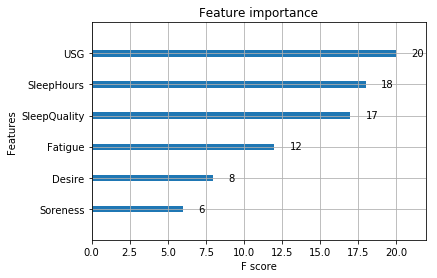

In [257]:
plot_importance(model)

In [224]:
accuracy_parameters_df = pd.DataFrame(columns=["n_estimators", "max_depth", "learning_rate", 
                                               "reglambda", "missing", "objective"])
best_accuracy = 42.14

In [225]:
range(0,10,100)

range(0, 10, 100)

In [226]:

def exhaustive_search(X_train, X_test, y_train, y_test):
    for n_estimators in range(0,100):
        for max_depth in range(0,20):
            for learning_rate in range(0,10,100):
                learning_rate_float = learning_rate / 100.0
                model = XGBClassifier(objective = "multi:softprob", missing = None, n_estimators = n_estimators, 
                                     max_depth = max_depth, learning_rate = learning_rate, reglambda=1)
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                predictions = [round(value) for value in y_pred]
                accuracy = accuracy_score(y_test, predictions) 
                if accuracy > best_accuracy:
                    accuracy_parameters_df.append([n_estimators, max_depth, learning_rate, 1, None, "multi:softprob"])
                
    

In [227]:
exhaustive_search(X_train, X_test, y_train, y_test)

XGBoostError: b'value 0 for Parameter num_class should be greater equal to 1'

In [228]:
print(accuracy_parameters_df)

Empty DataFrame
Columns: [n_estimators, max_depth, learning_rate, reglambda, missing, objective]
Index: []


In [229]:
model_SVM = svm.SVC(gamma='scale', decision_function_shape='ovo')
model_SVM.fit(X_train, y_train)

y_pred_SVM = model_SVM.predict(X_test)
predictions_SVM = [round(value) for value in y_pred_SVM]

accuracy_SVM = accuracy_score(y_test, predictions_SVM) 
print("Accuracy: %.2f%%" % (accuracy_SVM * 100.0))

TypeError: must be real number, not str

In [230]:
# K Neariest Neighbors
# K value list and cv scores list initialization. 
k_list = list(range(1,20))
cv_scores = []

# Fit the knn model and calculate the cv scores. 
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = "accuracy")
    cv_scores.append(scores.mean()) 
    
k_df = pd.DataFrame({"K":k_list, "CV_Scores":cv_scores})
print(k_df)

     K  CV_Scores
0    1   0.634083
1    2   0.559955
2    3   0.667229
3    4   0.612048
4    5   0.719260
5    6   0.673541
6    7   0.727147
7    8   0.711386
8    9   0.738183
9   10   0.722410
10  11   0.731871
11  12   0.722397
12  13   0.742907
13  14   0.736595
14  15   0.742920
15  16   0.735033
16  17   0.744482
17  18   0.738183
18  19   0.747632


In [231]:
# Initialize the knn model with k = 13 neighbors
knn = KNeighborsClassifier(n_neighbors = 17)
# Fit the model with trainning data. 
knn.fit(X_train, y_train)
# Predicting the test data. 
pred = knn.predict(X_test)
# Evaluate accuracy
print("Accuracy: ", knn.score(X_test, y_test))

Accuracy:  0.7861635220125787


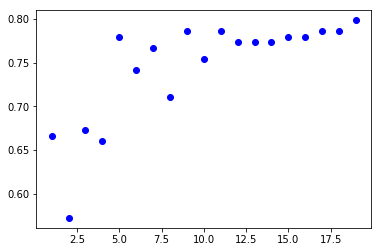

In [232]:
k_list = list(range(1,20))
fit_scores = []

# Just curious about how each k performs on test data. 
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    fit_scores.append(knn.score(X_test, y_test))
    
plt.plot(k_list, fit_scores, "o", color = "blue")

In [233]:
def pred(model):
    pred_res = model.predict(X_test)
    prediction = [round(value) for value in pred_res]
    accuracy = accuracy_score(y_test, prediction) 
    return accuracy

In [234]:
# Logistic Regression
model_logis = LogisticRegression(solver="newton-cg").fit(X_train, y_train)
accuracy_logis = pred(model_logis)
print(accuracy_logis)

0.7987421383647799


In [235]:
# Decision Tree: 
model_decTree = DecisionTreeClassifier().fit(X_train, y_train)
accuracy_decTree = pred(model_decTree)
print(accuracy_decTree)

0.6792452830188679


In [241]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100,
                                  bootstrap=False,
                                  max_depth=21,
                                  min_impurity_decrease=2,
                                  min_samples_leaf=20)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
predictions_rf = [round(value) for value in y_pred_rf]

accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Accuracy: %.2f%%" % (accuracy_rf * 100.0))

Accuracy: 79.87%


In [ ]:
# LightBGM